# Data Download and Exploration

This code means that the notebook will re-import your source code in `src` when it is edited (the default is not to re-import, because most modules are assumed not to change over time).  It's a good idea to include it in any exploratory notebook that uses `src` code

In [1]:
%load_ext autoreload
%autoreload 2

This snippet allows the notebook to import from the `src` module.  The directory structure looks like:

```
├── notebooks          <- Jupyter notebooks. Naming convention is a number (for ordering)
│   │                     followed by the topic of the notebook, e.g.
│   │                     01_data_collection_exploration.ipynb
│   └── exploratory    <- Raw, flow-of-consciousness, work-in-progress notebooks
│   └── report         <- Final summary notebook(s)
│
├── src                <- Source code for use in this project
│   ├── data           <- Scripts to download and query data
│   │   ├── sql        <- SQL scripts. Naming convention is a number (for ordering)
│   │   │                 followed by the topic of the script, e.g.
│   │   │                 03_create_pums_2017_table.sql
│   │   ├── data_collection.py
│   │   └── sql_utils.py
```

So we need to go up two "pardir"s (parent directories) to import the `src` code from this notebook.  You'll want to include this code at the top of any notebook that uses the `src` code.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The code to download all of the data and load it into a SQL database is in the `data` module within the `src` module.  You'll only need to run `download_data_and_load_into_sql` one time for the duration of the project.

In [3]:
from src.data import data_collection

This line may take as long as 10-20 minutes depending on your network connection and computer specs

In [4]:
data_collection.download_data_and_load_into_sql()

Successfully created database and all tables

Successfully downloaded ZIP file
    https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_pwa.zip
    
Successfully downloaded GZIP file
    https://lehd.ces.census.gov/data/lodes/LODES7/wa/wac/wa_wac_S000_JT00_2017.csv.gz
    
Successfully downloaded GZIP file
    https://lehd.ces.census.gov/data/lodes/LODES7/wa/wa_xwalk.csv.gz
    
Successfully downloaded CSV file
    https://www2.census.gov/geo/docs/maps-data/data/rel/2010_Census_Tract_to_2010_PUMA.txt
    
Successfully loaded CSV file into `pums_2017` table
        
Successfully loaded CSV file into `puma_names_2010` table
        
Successfully loaded CSV file into `wa_jobs_2017` table
        
Successfully loaded CSV file into `wa_geo_xwalk` table
        
Successfully loaded CSV file into `ct_puma_xwalk` table
        


Now it's time to explore the data!

In [4]:
import psycopg2
import pandas as pd
import sqlite3

In [5]:
DBNAME = "opportunity_youth"

In [6]:
conn = psycopg2.connect(dbname=DBNAME)
cur = conn.cursor()

In [7]:
df = pd.read_sql("SELECT * FROM pums_2017 LIMIT 10;", conn)

Notice the `LIMIT 10` above.  These tables have a large amount of data in them and **your goal is to use SQL to create your main query, not Pandas**.  Pandas can technically do everything that you need to do, but it will be much slower and more inefficient.  Nevertheless, Pandas is still a useful tool for exploring the data and getting a basic sense of what you're looking at.

In [8]:
df.head()

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2013000000006,9,01,11606,4,53,1061971,27.0,68.0,...,53.0,24.0,39.0,24.0,7.0,27.0,8.0,46.0,25.0,50.0
1,P,2013000000006,9,02,11606,4,53,1061971,22.0,66.0,...,49.0,21.0,38.0,20.0,7.0,25.0,8.0,41.0,22.0,47.0
2,P,2013000000012,9,01,10100,4,53,1061971,22.0,72.0,...,24.0,22.0,25.0,7.0,21.0,35.0,6.0,22.0,6.0,37.0
3,P,2013000000012,9,02,10100,4,53,1061971,19.0,64.0,...,21.0,18.0,19.0,7.0,17.0,29.0,6.0,19.0,6.0,29.0
4,P,2013000000038,9,01,11505,4,53,1061971,4.0,52.0,...,4.0,1.0,2.0,8.0,8.0,1.0,4.0,6.0,1.0,4.0


In [9]:
pd.read_sql(
"""
SELECT *
FROM pums_2017
WHERE agep BETWEEN 16.0 AND 24.0
AND puma IN ('11610','11611','11613','11614','11615')
AND esr in ('3', '6')
AND sch = '1'
ORDER BY agep ASC
LIMIT 10;
""", conn)

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2014000732829,9,04,11613,4,53,1045195,21.0,16.0,...,6.0,15.0,17.0,22.0,8.0,28.0,32.0,25.0,30.0,16.0
1,P,2016001052457,9,02,11610,4,53,1029257,28.0,16.0,...,24.0,8.0,24.0,29.0,48.0,44.0,10.0,9.0,48.0,47.0
2,P,2017001063337,9,03,11611,4,53,1011189,12.0,16.0,...,3.0,12.0,10.0,4.0,11.0,4.0,21.0,21.0,11.0,11.0
3,P,2017000648807,9,02,11614,4,53,1011189,4.0,16.0,...,4.0,5.0,4.0,4.0,1.0,4.0,7.0,1.0,8.0,1.0
4,P,2013000303198,9,04,11613,4,53,1061971,10.0,16.0,...,12.0,20.0,3.0,10.0,10.0,16.0,9.0,21.0,20.0,11.0
5,P,2014000707906,9,03,11614,4,53,1045195,44.0,16.0,...,14.0,42.0,40.0,51.0,44.0,48.0,57.0,31.0,14.0,12.0
6,P,2015000650843,9,03,11615,4,53,1035988,12.0,16.0,...,14.0,3.0,14.0,15.0,14.0,4.0,21.0,22.0,20.0,11.0
7,P,2015000639047,9,05,11614,4,53,1035988,12.0,16.0,...,12.0,10.0,20.0,11.0,20.0,11.0,13.0,12.0,4.0,18.0
8,P,2014000440342,9,04,11614,4,53,1045195,26.0,16.0,...,25.0,22.0,24.0,24.0,6.0,7.0,26.0,24.0,25.0,23.0
9,P,2015001455204,9,03,11614,4,53,1035988,8.0,16.0,...,14.0,2.0,6.0,14.0,3.0,7.0,11.0,3.0,7.0,2.0


agep - age
  * we want youths that are 16 ~ 24

esr - employment status record
  * 3 = unemployed
  * 6 = not in labor force
  
puma - region
  * 11610 central king county
  * 11611 west central king county
  * 11612 far southwest king county
  * 11613 southwest central king county
  * 11614 southwest king county
  * 11615 southeast king county
  
sch - school enrollment
  * sch = 1 means they aren't in school

In [10]:
# created a dict of information that takes information from the 2016 report
youth_past = {
    'youth_pop':226909,
    'oy_pop': 18816,
    
    'oy_no_ged': 5639,
    'oy_highschool': 7400,
    'oy_some_college': 3608,
    'oy_college': 2169,
    
    'oy_22to24': 8279,
    'oy_19to21': 7715,
    'oy_16to18': 2822,
    
    'oy_black': 6397,
    'oy_latino_hispanic': 5269,
    'oy_white': 3763,
    'oy_other': 3387,
}

# created a dict with no information that will be used to contain information from the 2017 data table
youth_curr = {
    'youth_pop': -1,
    'oy_pop': -1,
    
    'oy_no_ged': -1,
    'oy_highschool': -1,
    'oy_some_college': -1,
    'oy_college': -1,
    
    'oy_22to24': -1,
    'oy_19to21': -1,
    'oy_16to18': -1,
    
    'oy_black': -1,
    'oy_latino_hispanic': -1,
    'oy_white': -1,
    'oy_other': -1,
}

In [11]:
# number of youths in our dataset, from ages 16 - 24 
youth = pd.read_sql(
"""
SELECT *
FROM pums_2017
WHERE agep BETWEEN 16.0 AND 24.0
AND puma IN ('11606', '11607', '11608', '11609', '11610','11611','11612', '11613','11614','11615', '116156')
""", conn)
youth_curr['youth_pop'] = youth.shape[0]

In [12]:
# number of youths in our dataset that match the description of a OY
oy_youth = pd.read_sql(
"""
SELECT *
FROM pums_2017
WHERE agep BETWEEN 16.0 AND 24.0
AND puma IN ('11606', '11607', '11608', '11609', '11610','11611','11612', '11613','11614','11615', '116156')
AND esr in ('3', '6')
AND sch = '1'
""", conn)
youth_curr['oy_pop'] = oy_youth.shape[0]

In [13]:
# mapping to reduce number of categories in df['schl']
# no highschool or ged
map_dict = dict.fromkeys(['bb','01','02','03','04','05','06','07',
                          '08','09','10','11','12','13','14','15'], 0)
# highschool and/or ged
map_dict.update(dict.fromkeys(['16', '17'], 1))
# some college
map_dict.update(dict.fromkeys(['18', '19'], 2))
# college degree and more
map_dict.update(dict.fromkeys(['20', '21', '22', '23', '24'], 3))

# create a new column 'sch_m' that maps the dict onto 'schl'
oy_youth['sch_m'] = oy_youth['schl'].replace(map_dict)

sch = oy_youth['sch_m'].value_counts()

# update the dict with mapped variables
youth_curr['oy_no_ged'] = sch[0]
youth_curr['oy_highschool'] = sch[1]
youth_curr['oy_some_college'] = sch[2]
youth_curr['oy_college'] = sch[3]

In [14]:
# mapping to reduce number of categories in df['schl']
# no highschool or ged
map_dict = dict.fromkeys(['bb','01','02','03','04','05','06','07',
                          '08','09','10','11','12','13','14','15'], 0)
# highschool and/or ged
map_dict.update(dict.fromkeys(['16', '17'], 1))
# some college
map_dict.update(dict.fromkeys(['18', '19'], 2))
# college degree and more
map_dict.update(dict.fromkeys(['20', '21', '22', '23', '24'], 3))

# create a new column 'sch_m' that maps the dict onto 'schl'
oy_youth['sch_m'] = oy_youth['schl'].replace(map_dict)

sch = oy_youth['sch_m'].value_counts()

# update the dict with mapped variables
youth_curr['oy_no_ged'] = sch[0]
youth_curr['oy_highschool'] = sch[1]
youth_curr['oy_some_college'] = sch[2]
youth_curr['oy_college'] = sch[3]

In [15]:
oy_youth['age_m'] = oy_youth['agep'].astype(str)

map_dict = dict.fromkeys(['22.0', '23.0', '24.0'], 0)
map_dict.update(dict.fromkeys(['19.0', '20.0', '21.0'], 1))
map_dict.update(dict.fromkeys(['16.0', '17.0', '18.0'], 2))

oy_youth['age_m'] = oy_youth['age_m'].replace(map_dict)

age = oy_youth['age_m'].value_counts()

youth_curr['oy_22to24'] = age[0]
youth_curr['oy_19to21'] = age[1]
youth_curr['oy_16to18'] = age[2]

In [16]:
# black ethnicity
map_dict = dict.fromkeys(['2'], 0)
# latino or hispanic
# skipping latino and hispanic here due to existing latino/hispanic flag
# white ethnicity
map_dict.update(dict.fromkeys(['1'], 2))
# other
map_dict.update(dict.fromkeys(['3', '4', '5', '6', '7', '8', '9'], 3))

# create a new column 'sch_m' that maps the dict onto 'schl'
oy_youth['race_m'] = oy_youth['rac1p'].replace(map_dict)

oy_youth.loc[oy_youth['hisp'] != '01', 'race_m'] = 1
oy_youth.loc[oy_youth['racblk'] == '1', 'race_m'] = 0

race = oy_youth['race_m'].value_counts()

# # update the dict with mapped variables
youth_curr['oy_black'] = race[0]
youth_curr['oy_latino_hispanic'] = race[1]
youth_curr['oy_white'] = race[2]
youth_curr['oy_other'] = race[3]

In [17]:
youth_past

{'youth_pop': 226909,
 'oy_pop': 18816,
 'oy_no_ged': 5639,
 'oy_highschool': 7400,
 'oy_some_college': 3608,
 'oy_college': 2169,
 'oy_22to24': 8279,
 'oy_19to21': 7715,
 'oy_16to18': 2822,
 'oy_black': 6397,
 'oy_latino_hispanic': 5269,
 'oy_white': 3763,
 'oy_other': 3387}

In [18]:
youth_curr

{'youth_pop': 5741,
 'oy_pop': 555,
 'oy_no_ged': 168,
 'oy_highschool': 231,
 'oy_some_college': 91,
 'oy_college': 65,
 'oy_22to24': 285,
 'oy_19to21': 195,
 'oy_16to18': 75,
 'oy_black': 68,
 'oy_latino_hispanic': 75,
 'oy_white': 278,
 'oy_other': 134}

In [19]:
# extra imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

p = youth_past
c = youth_curr

colorpc = ['#fc766aff','#5b84b1ff']
colorpie = ['#a89c94ff', '#ff4f58ff', '#669db3ff', '#f0f6f7ff']

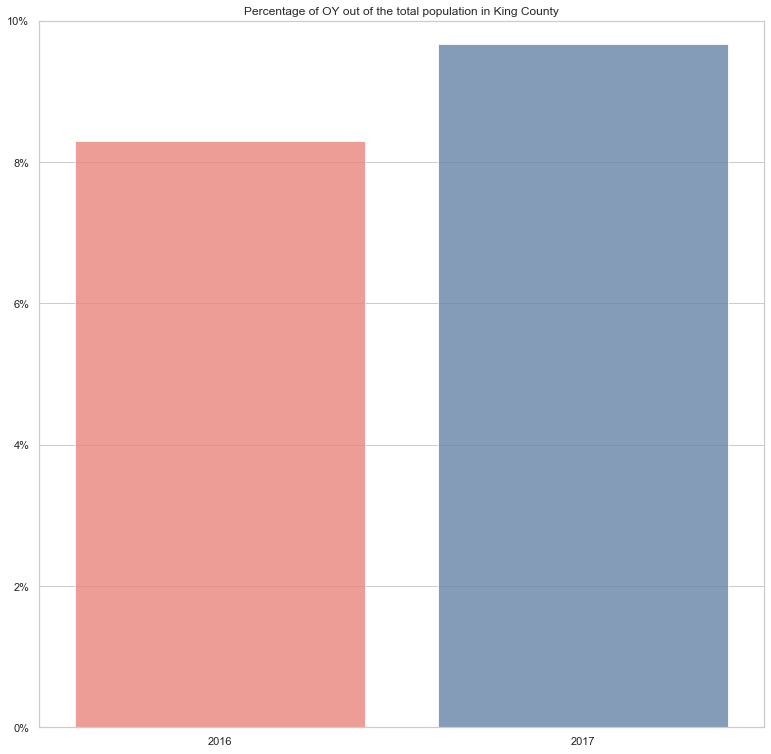

In [123]:
fig, ax = plt.subplots(figsize = (13,13))
ax = sns.barplot(x = ['2016', '2017'], y = [p['oy_pop'] / p['youth_pop'], c['oy_pop']/c['youth_pop']],
                 palette = colorpc, alpha = 0.8)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set(ylim = (0,0.10))
plt.title('Percentage of OY out of the total population in King County')
plt.show()

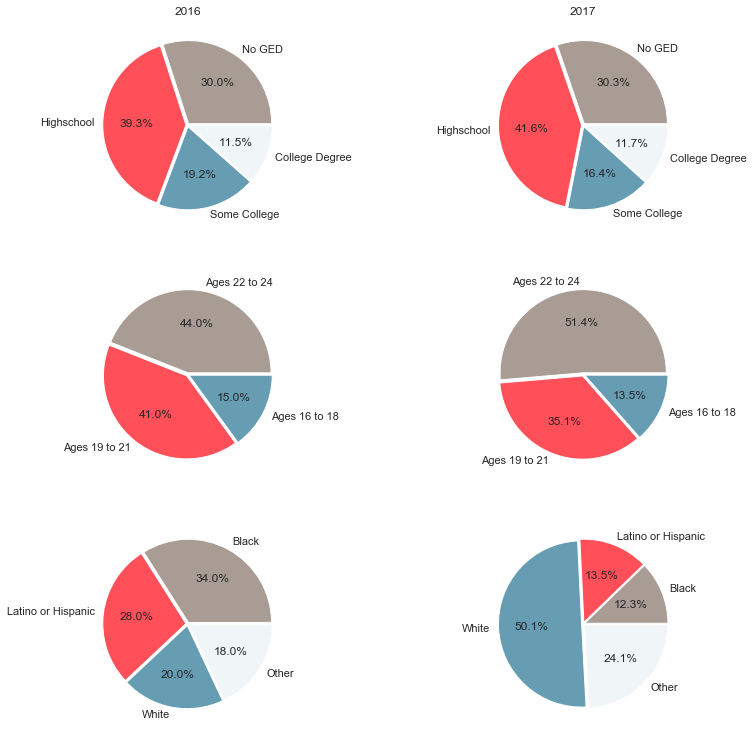

In [126]:
labels = ['No GED', 'Highschool', 'Some College', 'College Degree']
school_p = [p['oy_no_ged'], p['oy_highschool'], p['oy_some_college'], p['oy_college']]
school_c = [c['oy_no_ged'], c['oy_highschool'], c['oy_some_college'], c['oy_college']]


fg1, ax = plt.subplots(3,2, figsize = (13,13))

ax[0,0].pie(school_p, labels=labels, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02,0.02))
ax[0,1].pie(school_c, labels=labels, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02,0.02))
ax[0,0].set_title('2016')
ax[0,1].set_title('2017')

labela = ['Ages 22 to 24', 'Ages 19 to 21', 'Ages 16 to 18']
age_p = [p['oy_22to24'], p['oy_19to21'], p['oy_16to18']]
age_c = [c['oy_22to24'], c['oy_19to21'], c['oy_16to18']]
ax[1,0].pie(age_p, labels=labela, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02))
ax[1,1].pie(age_c, labels=labela, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02))

labelr = ['Black', 'Latino or Hispanic', 'White', 'Other']
race_p = [p['oy_black'], p['oy_latino_hispanic'], p['oy_white'], p['oy_other']]
race_c = [c['oy_black'], c['oy_latino_hispanic'], c['oy_white'], c['oy_other']]
ax[2,0].pie(race_p, labels=labelr, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02,0.02))
ax[2,1].pie(race_c, labels=labelr, autopct = '%1.1f%%', colors = colorpie, explode = (0.02,0.02,0.02,0.02))

plt.show()

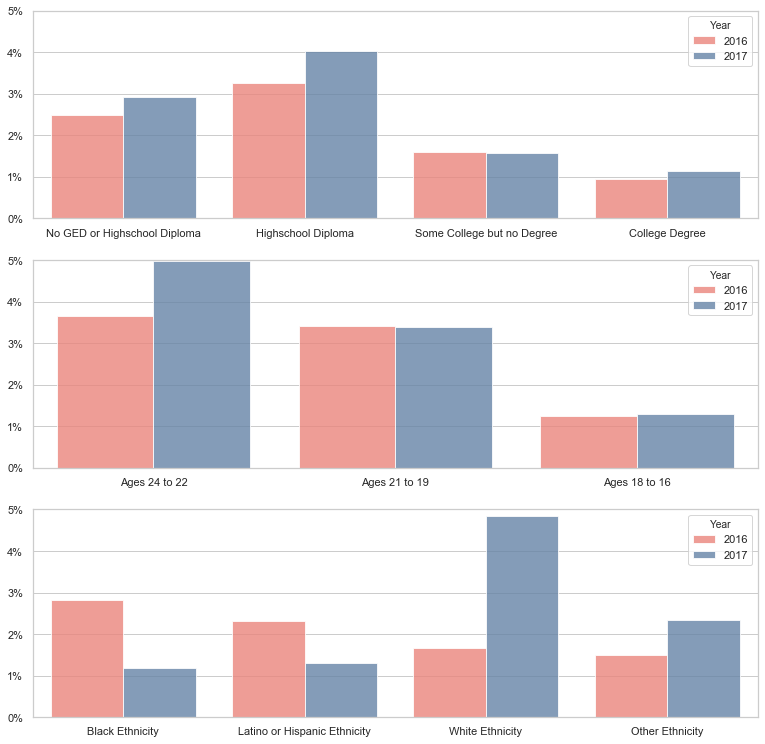

In [125]:
df = pd.DataFrame(columns = ['school', 'age', 'race', 'time', 'percentage'])

df['type'] = list(p.keys()) * 2
df['Year'] = ['2016'] * 13 + ['2017'] * 13
df['percentage'] = [i/p['youth_pop'] for i in list(p.values())] + [i/c['youth_pop'] for i in list(c.values())]

df.drop([0,1,13,14], inplace = True)
df.reset_index(drop = True, inplace = True)

school = list(p.keys())[2:6]
age = list(p.keys())[6:9]
race = list(p.keys())[9:]

fg1, axs = plt.subplots(nrows = 3, figsize = (13,13))
sns.barplot(x = df.loc[df['type'].isin(school)]['type'], y = df['percentage'], hue = df['Year'], ax = axs[0], palette = colorpc, alpha = 0.8)
sns.barplot(x = df.loc[df['type'].isin(age)]['type'], y = df['percentage'], hue = df['Year'], ax = axs[1], palette = colorpc, alpha = 0.8)
sns.barplot(x = df.loc[df['type'].isin(race)]['type'], y = df['percentage'], hue = df['Year'], ax = axs[2], palette = colorpc, alpha = 0.8)

axs[0].set_xticklabels(['No GED or Highschool Diploma', 'Highschool Diploma', 'Some College but no Degree', 'College Degree'])
axs[1].set_xticklabels(['Ages 24 to 22', 'Ages 21 to 19', 'Ages 18 to 16'])
axs[2].set_xticklabels(['Black Ethnicity', 'Latino or Hispanic Ethnicity', 'White Ethnicity', 'Other Ethnicity'])

for i in range(len(axs)): 
    axs[i].set(ylim = (0, 0.05), xlabel = (''), ylabel = (''))
    axs[i].set_yticklabels(['{:,.0%}'.format(x) for x in axs[i].get_yticks()])

plt.show()

In [331]:
conn.close()